<a href="https://colab.research.google.com/github/Jorgecuenca1/Tps_ProcesamientoLenguajeNatural/blob/main/5_clothing_ecommerce_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 32.0MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


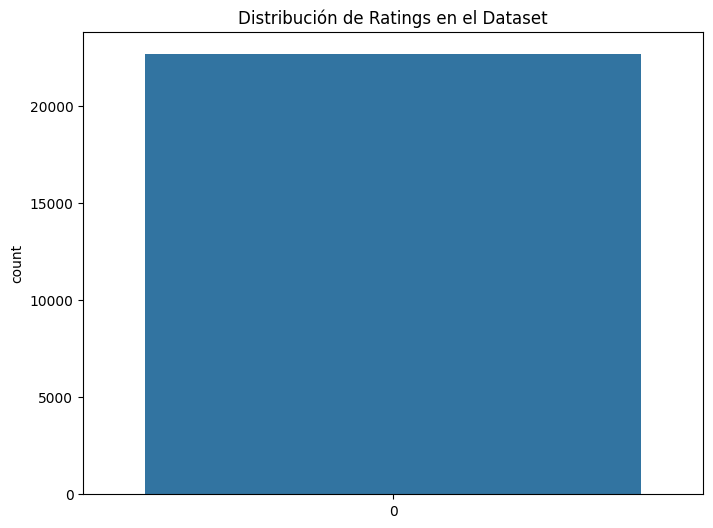

Hay 22641 reviews para evaluar.
La longitud del corpus es de 7011643 caracteres.
Los primeros 20 tokens son:  ['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']
Hay 1372203 tokens en el corpus.


In [24]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase
plt.figure(figsize=(8, 6))
sns.countplot(df_reviews['Rating'])
plt.title('Distribución de Ratings en el Dataset')
plt.show()

# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].values

# Alumno: Cuantas reviews (rows) hay para evaluar?
print(f"Hay {len(reviews)} reviews para evaluar.")

# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)

# Alumno: ¿Cuál es la longitud de ese corpus?
print(f"La longitud del corpus es de {len(corpus)} caracteres.")

# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automáticamente quita los signos de puntuación y pasa el texto a minúsculas
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print("Los primeros 20 tokens son: ", tokens[:20])

# Alumno: ¿Cuántos tokens/palabras hay?
print(f"Hay {len(tokens)} tokens en el corpus.")

# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> el número máximo de palabras a mantener, basado en la frecuencia de palabras.
# Solo se mantendrán las palabras más comunes num_words-1.
from keras.preprocessing.text import Tokenizer

num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)

vocab_size = num_words


In [47]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tokenizer.word_index
print('Se encontraron %s tokens únicos.' % len(word_index))

# Alumno: Convertir las palabras/tokens a números
sequences = tokenizer.texts_to_sequences(reviews)

# Alumno: Determinar cual es la oración más larga
max_sequence_len = max(len(s) for s in sequences)
print(f"La longitud máxima de las secuencias es: {max_sequence_len}")

# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences

maxlen = max_sequence_len
X = pad_sequences(sequences, maxlen=maxlen)

# Alumno: Observar las dimensiones de la variable input
print(f"Dimensiones de la entrada: {X.shape}")

# Alumno tomar la columna rating y almacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['Rating'].values
y = to_categorical(y, num_classes=5)

# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Alumno: determinar la dimensiones de entrada y salida
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

### 2 - Entrenar el modelo con Embeddings + LSTM
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=50, input_length=input_dim))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Se encontraron 14847 tokens únicos.
La longitud máxima de las secuencias es: 115
Dimensiones de la entrada: (22641, 115)
Epoch 1/10
283/283 [==============================] - 22s 66ms/step - loss: 1.1127 - accuracy: 0.5590 - val_loss: 0.8988 - val_accuracy: 0.6328
Epoch 2/10
283/283 [==============================] - 7s 24ms/step - loss: 0.9188 - accuracy: 0.6207 - val_loss: 0.8922 - val_accuracy: 0.6441
Epoch 3/10
283/283 [==============================] - 4s 14ms/step - loss: 0.8674 - accuracy: 0.6388 - val_loss: 0.8527 - val_accuracy: 0.6399
Epoch 4/10
283/283 [==============================] - 3s 10ms/step - loss: 0.8293 - accuracy: 0.6520 - val_loss: 0.8744 - val_accuracy: 0.6386
Epoch 5/10
283/283 [==============================] - 4s 15ms/step - loss: 0.8051 - accuracy: 0.6623 - val_loss: 0.8557 - val_accuracy: 0.6416
Epoch 6/10
283/283 [==============================] - 3s 11ms/step - loss: 0.7818 - accuracy: 0.6671 - val_loss: 0.8641 - val_accuracy: 0.6377
Epoch 7/10
283/283 [

In [48]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 115, 50)           100000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                                 
Total params: 131,685
Trainable params: 131,685
Non-trainable params: 0
_________________________________________________________________


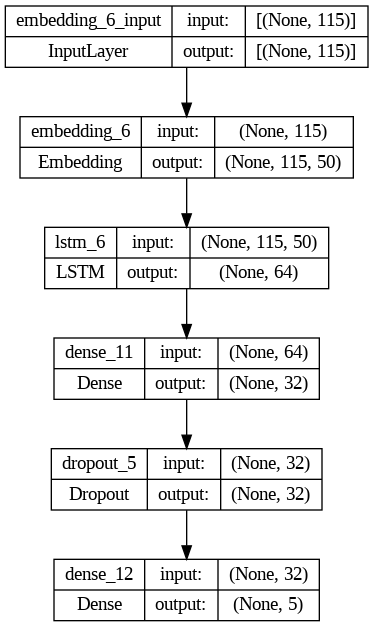

In [49]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

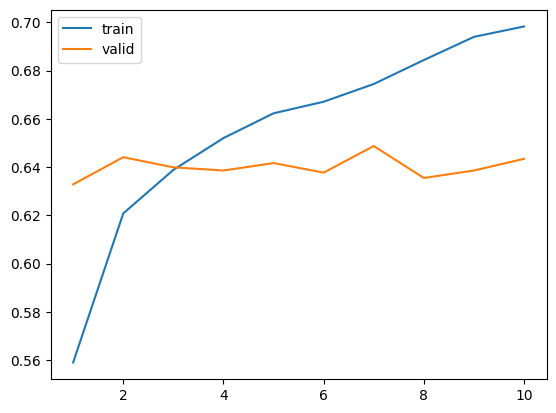

142/142 [==============================] - 1s 5ms/step - loss: 0.9241 - accuracy: 0.6434


[0.9241015315055847, 0.6434091329574585]

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()
model.evaluate(X_test, y_test)
# Como este modelo es binario podemos calcular la curva ROC


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [7]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

In [8]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

In [9]:
# Alumno: Concatenar todas las reviews para armar el corpus

In [10]:
# Alumno: ¿Cuál es la longitud de ese corpus?

In [11]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

In [12]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [13]:
# Alumno: ¿Cuántos tokens/palabras hay?

In [14]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

In [15]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

In [16]:
# Alumno: Convertir las palabras/tokens a números

In [17]:
# Alumno: Determinar cual es la oración más larga

In [18]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

In [19]:
# Alumno: Observar las dimensiones de la variable input

In [20]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

In [21]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

In [22]:
# Alumno: determinar la dimensiones de entrada y salida

### 2 - Entrenar el modelo con Embeddings + LSTM

In [26]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [35]:
# Entrenar un modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
model.add(Embedding(input_dim=vocab_size+1, output_dim=128, input_length=input_shape))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
#model.add(Dropout(0.2))
#model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

#model.add(Dense(units=64, activation='relu'))
#model.add(Dropout(rate=0.2))
model.add(Dense(units=output_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 128)          256128    
                                                                 
 bidirectional (Bidirectiona  (None, 115, 256)         263168    
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 115, 5)            1285      
                                                                 
Total params: 520,581
Trainable params: 520,581
Non-trainable params: 0
_________________________________________________________________


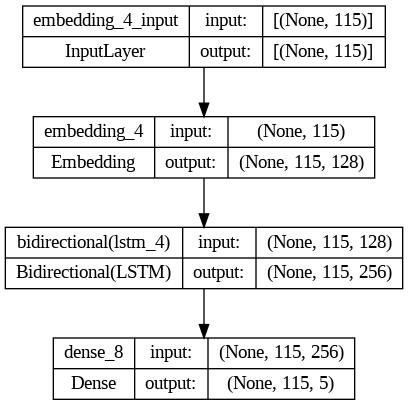

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [44]:


hist = model.fit(X_train, y_train, epochs=15, validation_split=0.3)
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()
model.evaluate(X_test, y_test)
# Como este modelo es binario podemos calcular la curva ROC
curva_roc(model, X_test, y_test)

ValueError: ignored